In [1]:
from numpy.random import seed
seed(35)
from tensorflow import set_random_seed
set_random_seed(35)

import numpy as np
import pandas as pd
import keras
from Autoencoders import (autoencoder,fit_model_dic,plot_loss_dic,
                          create_loss_param_table,save_ae_history,
                          save_ae_dic,make_ae_dict_from_dict,model_node_wrap)
from ae_designs_depth import model_7h
from custom_loss import (recon_loss_abs, make_recon_loss_combi,sparse_recon_loss_abs,
                         make_sparse_recon_loss_combi,
                         sparse_recon_loss_mse, make_sparse_recon_loss_var)

from keras.models import  load_model
from keras.callbacks import EarlyStopping

from data_manipulation import remove_outlier,augment_x, augment_x_linear

from general_loader import ds_from_db
from secTools import yamlLoad
from sklearn.model_selection import train_test_split
import yaml

from keras.initializers import glorot_uniform, glorot_normal
from keras.optimizers import Adam

import matplotlib.pyplot as plt
from keras.utils import plot_model
import os
import keras.backend as K


/home/anywayed/anaconda3/envs/keras/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:

ds_dic={'pickle_file':'ds180704'}
ds=ds_from_db(**ds_dic)
ds.normalise(['pAssets','pLiabilitiesAndStockholdersEquity'],reorder=True,inplace=True)
ds.normalise(['pAssets','pLiabilitiesAndStockholdersEquity'],reorder=True,inplace=True)

#I can't figure out why I need to do this twice. 

Number of records dropped where no normaliser: 326
Number of records dropped where no normaliser: 119


In [1]:
X=ds.FT.values
Y=ds.FT.index.values
X,Y=remove_outlier(X,2.5,Y=Y,replace_nan=True)

assert(~np.any(np.isnan(X)))

X=X[:,0:200]
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.25,random_state=35)


sparse_recon_loss_combi=make_sparse_recon_loss_combi(0.8)
sparse_recon_loss_var=make_sparse_recon_loss_var(sparse_recon_loss_combi)

loss=sparse_recon_loss_combi

metrics=[sparse_recon_loss_mse,sparse_recon_loss_abs,sparse_recon_loss_var]

test_data=[x_test,x_test]
train_data=[x_train,x_train]

x_aug=augment_x(x_train,ds,repeats=10,fit_col='Assets',seed=22)
x_train_lin_aug=augment_x_linear(x_train,reps=10000,pairs=True)
x_train_lin_aug_aug=augment_x(np.vstack((x_train_lin_aug,x_train)),ds,repeats=4,fit_col='Assets',seed=22)

x_train_aug=np.vstack((x_train,x_aug))
train_aug=[x_train_lin_aug_aug,x_train_lin_aug_aug]

#early stop setting below is default but explicitly stated here
ES=EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=5, verbose=1, mode='auto')

opt=Adam(lr=0.001)
ker_init=glorot_normal(seed=22)

train_dic={'loss':loss,
           'compile':True,'epochs':100,'batch_size':256,'optimizer':opt,
          'early_stop':ES,'metrics':metrics}

data_dic={'train_data':train_data,'test_data':test_data}
aug_data_dic={'train_data':train_aug,'test_data':test_data}

layer_p_dic={'drop_ra':0.05, 'g_noise':0.05, 'ker_init':ker_init}

NameError: name 'ds' is not defined

In [4]:
node_list=[[64,32,round(1.3*bot),bot,round(1.3*bot),32,64] for bot in range(4,17,4)]
node_list2=[[64,24,round(1.3*bot),bot,round(1.3*bot),24,64] for bot in range(4,17,4)]
node_list3=[[32,24,round(1.3*bot),bot,round(1.3*bot),24,32] for bot in range(4,17,4)]

node_list=node_list+node_list2+node_list3
node_list

[[64, 32, 5, 4, 5, 32, 64],
 [64, 32, 10, 8, 10, 32, 64],
 [64, 32, 16, 12, 16, 32, 64],
 [64, 32, 21, 16, 21, 32, 64],
 [64, 24, 5, 4, 5, 24, 64],
 [64, 24, 10, 8, 10, 24, 64],
 [64, 24, 16, 12, 16, 24, 64],
 [64, 24, 21, 16, 21, 24, 64],
 [32, 24, 5, 4, 5, 24, 32],
 [32, 24, 10, 8, 10, 24, 32],
 [32, 24, 16, 12, 16, 24, 32],
 [32, 24, 21, 16, 21, 24, 32]]

In [5]:
nw_names=[str(k) for k in node_list]
node_dic={str(k):k for k in node_list}
layer_dic={k:model_7h for k in nw_names}
layer_param_dic={k:layer_p_dic for k in nw_names}
for k,val in node_dic.items():
    layer_param_dic[k]={**layer_p_dic,**{'nodes':val}}
model_data_dic={k:aug_data_dic for k in nw_names}   

In [6]:
ae_dic=make_ae_dict_from_dict(layer_dic,layer_param_dic,model_data_dic,train_dic)

In [7]:

fit_model_dic(ae_dic)

[64, 32, 5, 4, 5, 32, 64]
Train on 124644 samples, validate on 7054 samples
Epoch 1/100
124644/124644 [==============================] - 5s 40us/step - loss: 0.1143 - sparse_recon_loss_mse: 0.1020 - sparse_recon_loss_abs: 0.1633 - sparse_recon_loss_var: 0.1566 - val_loss: 0.1004 - val_sparse_recon_loss_mse: 0.0889 - val_sparse_recon_loss_abs: 0.1466 - val_sparse_recon_loss_var: 0.1461
Epoch 2/100
124644/124644 [==============================] - 3s 22us/step - loss: 0.0833 - sparse_recon_loss_mse: 0.0712 - sparse_recon_loss_abs: 0.1317 - sparse_recon_loss_var: 0.1251 - val_loss: 0.0891 - val_sparse_recon_loss_mse: 0.0781 - val_sparse_recon_loss_abs: 0.1334 - val_sparse_recon_loss_var: 0.1373
Epoch 3/100
124644/124644 [==============================] - 3s 22us/step - loss: 0.0770 - sparse_recon_loss_mse: 0.0652 - sparse_recon_loss_abs: 0.1239 - sparse_recon_loss_var: 0.1177 - val_loss: 0.0858 - val_sparse_recon_loss_mse: 0.0747 - val_sparse_recon_loss_abs: 0.1301 - val_sparse_recon_loss_

Epoch 27/100
124644/124644 [==============================] - 3s 22us/step - loss: 0.0596 - sparse_recon_loss_mse: 0.0489 - sparse_recon_loss_abs: 0.1023 - sparse_recon_loss_var: 0.0944 - val_loss: 0.0776 - val_sparse_recon_loss_mse: 0.0677 - val_sparse_recon_loss_abs: 0.1171 - val_sparse_recon_loss_var: 0.1358
Epoch 28/100
124644/124644 [==============================] - 3s 22us/step - loss: 0.0593 - sparse_recon_loss_mse: 0.0486 - sparse_recon_loss_abs: 0.1021 - sparse_recon_loss_var: 0.0939 - val_loss: 0.0778 - val_sparse_recon_loss_mse: 0.0679 - val_sparse_recon_loss_abs: 0.1173 - val_sparse_recon_loss_var: 0.1383
Epoch 29/100
124644/124644 [==============================] - 3s 21us/step - loss: 0.0591 - sparse_recon_loss_mse: 0.0484 - sparse_recon_loss_abs: 0.1017 - sparse_recon_loss_var: 0.0936 - val_loss: 0.0775 - val_sparse_recon_loss_mse: 0.0677 - val_sparse_recon_loss_abs: 0.1166 - val_sparse_recon_loss_var: 0.1369
Epoch 30/100
124644/124644 [==============================] -

Epoch 15/100
124644/124644 [==============================] - 3s 23us/step - loss: 0.0636 - sparse_recon_loss_mse: 0.0527 - sparse_recon_loss_abs: 0.1071 - sparse_recon_loss_var: 0.0994 - val_loss: 0.0808 - val_sparse_recon_loss_mse: 0.0706 - val_sparse_recon_loss_abs: 0.1212 - val_sparse_recon_loss_var: 0.1369
Epoch 16/100
124644/124644 [==============================] - 3s 23us/step - loss: 0.0632 - sparse_recon_loss_mse: 0.0523 - sparse_recon_loss_abs: 0.1067 - sparse_recon_loss_var: 0.0988 - val_loss: 0.0807 - val_sparse_recon_loss_mse: 0.0707 - val_sparse_recon_loss_abs: 0.1209 - val_sparse_recon_loss_var: 0.1363
Epoch 17/100
124644/124644 [==============================] - 3s 24us/step - loss: 0.0630 - sparse_recon_loss_mse: 0.0521 - sparse_recon_loss_abs: 0.1064 - sparse_recon_loss_var: 0.0984 - val_loss: 0.0808 - val_sparse_recon_loss_mse: 0.0709 - val_sparse_recon_loss_abs: 0.1205 - val_sparse_recon_loss_var: 0.1376
Epoch 18/100
124644/124644 [==============================] -

Epoch 12/100
124644/124644 [==============================] - 3s 23us/step - loss: 0.0480 - sparse_recon_loss_mse: 0.0374 - sparse_recon_loss_abs: 0.0905 - sparse_recon_loss_var: 0.0771 - val_loss: 0.0583 - val_sparse_recon_loss_mse: 0.0482 - val_sparse_recon_loss_abs: 0.0987 - val_sparse_recon_loss_var: 0.1019
Epoch 13/100
124644/124644 [==============================] - 3s 23us/step - loss: 0.0475 - sparse_recon_loss_mse: 0.0369 - sparse_recon_loss_abs: 0.0899 - sparse_recon_loss_var: 0.0757 - val_loss: 0.0575 - val_sparse_recon_loss_mse: 0.0475 - val_sparse_recon_loss_abs: 0.0979 - val_sparse_recon_loss_var: 0.1036
Epoch 14/100
124644/124644 [==============================] - 3s 23us/step - loss: 0.0470 - sparse_recon_loss_mse: 0.0363 - sparse_recon_loss_abs: 0.0894 - sparse_recon_loss_var: 0.0749 - val_loss: 0.0569 - val_sparse_recon_loss_mse: 0.0469 - val_sparse_recon_loss_abs: 0.0970 - val_sparse_recon_loss_var: 0.1003
Epoch 15/100
124644/124644 [==============================] -

Epoch 24/100
124644/124644 [==============================] - 3s 23us/step - loss: 0.0415 - sparse_recon_loss_mse: 0.0313 - sparse_recon_loss_abs: 0.0824 - sparse_recon_loss_var: 0.0665 - val_loss: 0.0513 - val_sparse_recon_loss_mse: 0.0417 - val_sparse_recon_loss_abs: 0.0898 - val_sparse_recon_loss_var: 0.0951
Epoch 25/100
124644/124644 [==============================] - 3s 24us/step - loss: 0.0414 - sparse_recon_loss_mse: 0.0312 - sparse_recon_loss_abs: 0.0822 - sparse_recon_loss_var: 0.0665 - val_loss: 0.0513 - val_sparse_recon_loss_mse: 0.0417 - val_sparse_recon_loss_abs: 0.0897 - val_sparse_recon_loss_var: 0.0971
Epoch 26/100
124644/124644 [==============================] - 3s 24us/step - loss: 0.0413 - sparse_recon_loss_mse: 0.0311 - sparse_recon_loss_abs: 0.0820 - sparse_recon_loss_var: 0.0661 - val_loss: 0.0506 - val_sparse_recon_loss_mse: 0.0410 - val_sparse_recon_loss_abs: 0.0888 - val_sparse_recon_loss_var: 0.0949
Epoch 27/100
124644/124644 [==============================] -

Epoch 19/100
124644/124644 [==============================] - 3s 23us/step - loss: 0.0541 - sparse_recon_loss_mse: 0.0435 - sparse_recon_loss_abs: 0.0966 - sparse_recon_loss_var: 0.0872 - val_loss: 0.0654 - val_sparse_recon_loss_mse: 0.0554 - val_sparse_recon_loss_abs: 0.1055 - val_sparse_recon_loss_var: 0.1157
Epoch 20/100
124644/124644 [==============================] - 3s 24us/step - loss: 0.0539 - sparse_recon_loss_mse: 0.0433 - sparse_recon_loss_abs: 0.0964 - sparse_recon_loss_var: 0.0870 - val_loss: 0.0649 - val_sparse_recon_loss_mse: 0.0549 - val_sparse_recon_loss_abs: 0.1048 - val_sparse_recon_loss_var: 0.1176
Epoch 21/100
124644/124644 [==============================] - 3s 26us/step - loss: 0.0535 - sparse_recon_loss_mse: 0.0429 - sparse_recon_loss_abs: 0.0961 - sparse_recon_loss_var: 0.0859 - val_loss: 0.0643 - val_sparse_recon_loss_mse: 0.0543 - val_sparse_recon_loss_abs: 0.1043 - val_sparse_recon_loss_var: 0.1131
Epoch 22/100
124644/124644 [==============================] -

Epoch 5/100
124644/124644 [==============================] - 3s 23us/step - loss: 0.0601 - sparse_recon_loss_mse: 0.0489 - sparse_recon_loss_abs: 0.1048 - sparse_recon_loss_var: 0.0964 - val_loss: 0.0686 - val_sparse_recon_loss_mse: 0.0581 - val_sparse_recon_loss_abs: 0.1107 - val_sparse_recon_loss_var: 0.1151
Epoch 6/100
124644/124644 [==============================] - 4s 28us/step - loss: 0.0584 - sparse_recon_loss_mse: 0.0474 - sparse_recon_loss_abs: 0.1026 - sparse_recon_loss_var: 0.0943 - val_loss: 0.0669 - val_sparse_recon_loss_mse: 0.0564 - val_sparse_recon_loss_abs: 0.1091 - val_sparse_recon_loss_var: 0.1127
Epoch 7/100
124644/124644 [==============================] - 4s 28us/step - loss: 0.0571 - sparse_recon_loss_mse: 0.0461 - sparse_recon_loss_abs: 0.1008 - sparse_recon_loss_var: 0.0924 - val_loss: 0.0650 - val_sparse_recon_loss_mse: 0.0547 - val_sparse_recon_loss_abs: 0.1060 - val_sparse_recon_loss_var: 0.1102
Epoch 8/100
124644/124644 [==============================] - 4s 

124644/124644 [==============================] - 3s 23us/step - loss: 0.0453 - sparse_recon_loss_mse: 0.0348 - sparse_recon_loss_abs: 0.0875 - sparse_recon_loss_var: 0.0721 - val_loss: 0.0538 - val_sparse_recon_loss_mse: 0.0443 - val_sparse_recon_loss_abs: 0.0919 - val_sparse_recon_loss_var: 0.1096
Epoch 58/100
124644/124644 [==============================] - 3s 24us/step - loss: 0.0453 - sparse_recon_loss_mse: 0.0348 - sparse_recon_loss_abs: 0.0874 - sparse_recon_loss_var: 0.0720 - val_loss: 0.0537 - val_sparse_recon_loss_mse: 0.0442 - val_sparse_recon_loss_abs: 0.0918 - val_sparse_recon_loss_var: 0.1120
Epoch 00058: early stopping
[64, 32, 16, 12, 16, 32, 64]
Train on 124644 samples, validate on 7054 samples
Epoch 1/100
124644/124644 [==============================] - 4s 34us/step - loss: 0.0840 - sparse_recon_loss_mse: 0.0718 - sparse_recon_loss_abs: 0.1327 - sparse_recon_loss_var: 0.1259 - val_loss: 0.0769 - val_sparse_recon_loss_mse: 0.0659 - val_sparse_recon_loss_abs: 0.1211 - va

Epoch 25/100
124644/124644 [==============================] - 3s 22us/step - loss: 0.0457 - sparse_recon_loss_mse: 0.0355 - sparse_recon_loss_abs: 0.0869 - sparse_recon_loss_var: 0.0735 - val_loss: 0.0599 - val_sparse_recon_loss_mse: 0.0503 - val_sparse_recon_loss_abs: 0.0979 - val_sparse_recon_loss_var: 0.1144
Epoch 26/100
124644/124644 [==============================] - 3s 22us/step - loss: 0.0456 - sparse_recon_loss_mse: 0.0353 - sparse_recon_loss_abs: 0.0867 - sparse_recon_loss_var: 0.0733 - val_loss: 0.0598 - val_sparse_recon_loss_mse: 0.0502 - val_sparse_recon_loss_abs: 0.0980 - val_sparse_recon_loss_var: 0.1155
Epoch 27/100
124644/124644 [==============================] - 3s 22us/step - loss: 0.0455 - sparse_recon_loss_mse: 0.0352 - sparse_recon_loss_abs: 0.0865 - sparse_recon_loss_var: 0.0735 - val_loss: 0.0594 - val_sparse_recon_loss_mse: 0.0499 - val_sparse_recon_loss_abs: 0.0976 - val_sparse_recon_loss_var: 0.1135
Epoch 28/100
124644/124644 [==============================] -

Epoch 6/100
124644/124644 [==============================] - 3s 24us/step - loss: 0.0774 - sparse_recon_loss_mse: 0.0662 - sparse_recon_loss_abs: 0.1225 - sparse_recon_loss_var: 0.1183 - val_loss: 0.0909 - val_sparse_recon_loss_mse: 0.0803 - val_sparse_recon_loss_abs: 0.1332 - val_sparse_recon_loss_var: 0.1421
Epoch 7/100
124644/124644 [==============================] - 3s 24us/step - loss: 0.0751 - sparse_recon_loss_mse: 0.0639 - sparse_recon_loss_abs: 0.1199 - sparse_recon_loss_var: 0.1157 - val_loss: 0.0876 - val_sparse_recon_loss_mse: 0.0770 - val_sparse_recon_loss_abs: 0.1297 - val_sparse_recon_loss_var: 0.1406
Epoch 8/100
124644/124644 [==============================] - 3s 24us/step - loss: 0.0731 - sparse_recon_loss_mse: 0.0620 - sparse_recon_loss_abs: 0.1176 - sparse_recon_loss_var: 0.1132 - val_loss: 0.0863 - val_sparse_recon_loss_mse: 0.0759 - val_sparse_recon_loss_abs: 0.1279 - val_sparse_recon_loss_var: 0.1418
Epoch 9/100
124644/124644 [==============================] - 3s 

Epoch 3/100
124644/124644 [==============================] - 3s 23us/step - loss: 0.0659 - sparse_recon_loss_mse: 0.0547 - sparse_recon_loss_abs: 0.1111 - sparse_recon_loss_var: 0.1049 - val_loss: 0.0759 - val_sparse_recon_loss_mse: 0.0654 - val_sparse_recon_loss_abs: 0.1177 - val_sparse_recon_loss_var: 0.1266
Epoch 4/100
124644/124644 [==============================] - 3s 23us/step - loss: 0.0633 - sparse_recon_loss_mse: 0.0522 - sparse_recon_loss_abs: 0.1078 - sparse_recon_loss_var: 0.1016 - val_loss: 0.0741 - val_sparse_recon_loss_mse: 0.0638 - val_sparse_recon_loss_abs: 0.1154 - val_sparse_recon_loss_var: 0.1254
Epoch 5/100
124644/124644 [==============================] - 3s 25us/step - loss: 0.0614 - sparse_recon_loss_mse: 0.0504 - sparse_recon_loss_abs: 0.1054 - sparse_recon_loss_var: 0.0987 - val_loss: 0.0722 - val_sparse_recon_loss_mse: 0.0620 - val_sparse_recon_loss_abs: 0.1129 - val_sparse_recon_loss_var: 0.1247
Epoch 6/100
124644/124644 [==============================] - 3s 

Epoch 23/100
124644/124644 [==============================] - 3s 24us/step - loss: 0.0495 - sparse_recon_loss_mse: 0.0390 - sparse_recon_loss_abs: 0.0915 - sparse_recon_loss_var: 0.0795 - val_loss: 0.0662 - val_sparse_recon_loss_mse: 0.0568 - val_sparse_recon_loss_abs: 0.1039 - val_sparse_recon_loss_var: 0.1372
Epoch 00023: early stopping
[64, 24, 16, 12, 16, 24, 64]
Train on 124644 samples, validate on 7054 samples
Epoch 1/100
124644/124644 [==============================] - 5s 39us/step - loss: 0.0855 - sparse_recon_loss_mse: 0.0733 - sparse_recon_loss_abs: 0.1341 - sparse_recon_loss_var: 0.1271 - val_loss: 0.0782 - val_sparse_recon_loss_mse: 0.0671 - val_sparse_recon_loss_abs: 0.1227 - val_sparse_recon_loss_var: 0.1264
Epoch 2/100
124644/124644 [==============================] - 3s 24us/step - loss: 0.0649 - sparse_recon_loss_mse: 0.0534 - sparse_recon_loss_abs: 0.1108 - sparse_recon_loss_var: 0.1042 - val_loss: 0.0727 - val_sparse_recon_loss_mse: 0.0621 - val_sparse_recon_loss_abs:

Epoch 26/100
124644/124644 [==============================] - 3s 24us/step - loss: 0.0466 - sparse_recon_loss_mse: 0.0362 - sparse_recon_loss_abs: 0.0884 - sparse_recon_loss_var: 0.0740 - val_loss: 0.0587 - val_sparse_recon_loss_mse: 0.0490 - val_sparse_recon_loss_abs: 0.0976 - val_sparse_recon_loss_var: 0.1158
Epoch 27/100
124644/124644 [==============================] - 3s 24us/step - loss: 0.0464 - sparse_recon_loss_mse: 0.0360 - sparse_recon_loss_abs: 0.0882 - sparse_recon_loss_var: 0.0737 - val_loss: 0.0590 - val_sparse_recon_loss_mse: 0.0493 - val_sparse_recon_loss_abs: 0.0978 - val_sparse_recon_loss_var: 0.1171
Epoch 28/100
124644/124644 [==============================] - 3s 27us/step - loss: 0.0463 - sparse_recon_loss_mse: 0.0358 - sparse_recon_loss_abs: 0.0880 - sparse_recon_loss_var: 0.0735 - val_loss: 0.0588 - val_sparse_recon_loss_mse: 0.0491 - val_sparse_recon_loss_abs: 0.0976 - val_sparse_recon_loss_var: 0.1181
Epoch 29/100
124644/124644 [==============================] -

124644/124644 [==============================] - 3s 25us/step - loss: 0.0549 - sparse_recon_loss_mse: 0.0443 - sparse_recon_loss_abs: 0.0975 - sparse_recon_loss_var: 0.0881 - val_loss: 0.0671 - val_sparse_recon_loss_mse: 0.0571 - val_sparse_recon_loss_abs: 0.1069 - val_sparse_recon_loss_var: 0.1200
Epoch 40/100
124644/124644 [==============================] - 3s 25us/step - loss: 0.0548 - sparse_recon_loss_mse: 0.0441 - sparse_recon_loss_abs: 0.0973 - sparse_recon_loss_var: 0.0878 - val_loss: 0.0670 - val_sparse_recon_loss_mse: 0.0571 - val_sparse_recon_loss_abs: 0.1066 - val_sparse_recon_loss_var: 0.1203
Epoch 41/100
124644/124644 [==============================] - 3s 27us/step - loss: 0.0547 - sparse_recon_loss_mse: 0.0440 - sparse_recon_loss_abs: 0.0972 - sparse_recon_loss_var: 0.0874 - val_loss: 0.0670 - val_sparse_recon_loss_mse: 0.0571 - val_sparse_recon_loss_abs: 0.1066 - val_sparse_recon_loss_var: 0.1211
Epoch 42/100
124644/124644 [==============================] - 4s 33us/step

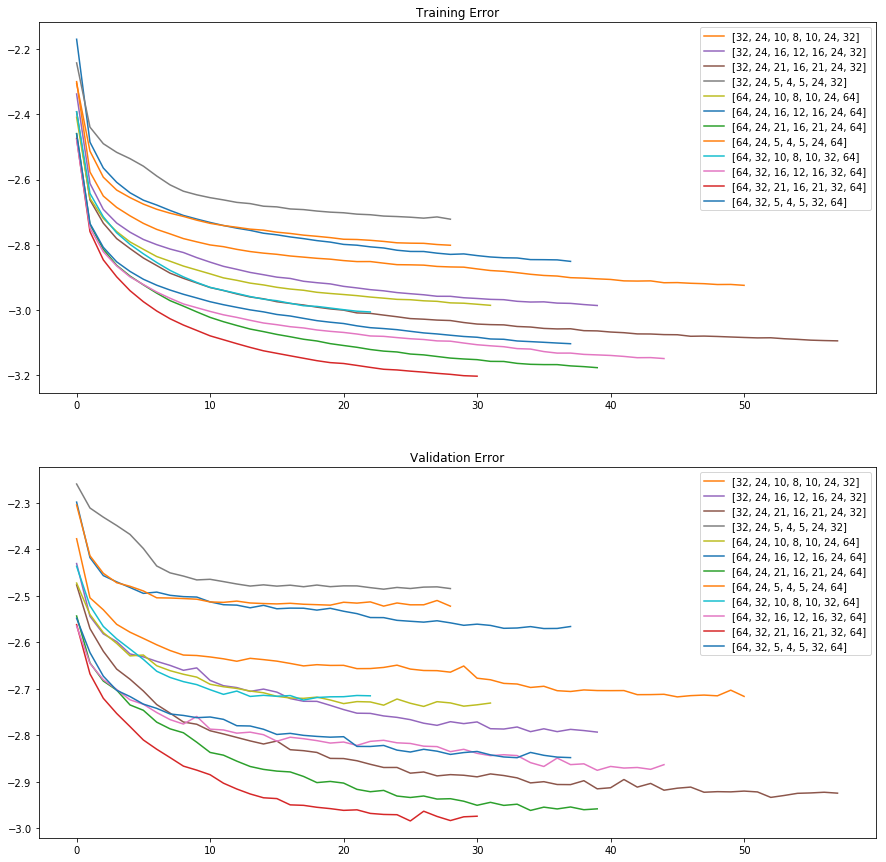

In [8]:
cwd=os.getcwd()

pic_loc=os.path.join(cwd,'ae_saves','7h','7h_width_loss_pic.png') 
dic_loc=os.path.join(cwd,'ae_saves','7h','7h_width_trainHistoryDict')


save_ae_dic(ae_dic,folder='ae_width_models/',path='./ae_saves/7h')

fig=plot_loss_dic(ae_dic)
fig.savefig(pic_loc)
save_ae_history(ae_dic,dic_loc)


In [10]:
columns=['Loss','mse loss','abs loss','std deviation']
df=create_loss_param_table(ae_dic,x_test,columns)

7054/7054 [==============================] - 0s 65us/step


In [11]:
import os
csv_loc=os.path.join(cwd,'ae_saves','7h','7h_width_trainloss.csv')
df.to_csv(csv_loc)

In [12]:
df

,Loss,mse loss,abs loss,std deviation,Trainable params,Untrainable params
"[64, 32, 21, 16, 21, 32, 64]",0.051115,0.041481,0.089651,0.085822,32518,106
"[64, 24, 21, 16, 21, 24, 64]",0.051931,0.042225,0.090756,0.088350,31110,90
"[32, 24, 21, 16, 21, 24, 32]",0.053714,0.044204,0.091751,0.093263,16646,90
"[64, 32, 16, 12, 16, 32, 64]",0.057109,0.047581,0.095223,0.096905,31872,96
"[64, 24, 16, 12, 16, 24, 64]",0.057981,0.048398,0.096313,0.100139,30544,80
"[32, 24, 16, 12, 16, 24, 32]",0.061252,0.051458,0.100424,0.099836,16080,80
"[64, 24, 10, 8, 10, 24, 64]",0.065201,0.055313,0.104754,0.107312,29988,68
"[32, 24, 10, 8, 10, 24, 32]",0.066142,0.056269,0.105630,0.107859,15524,68
"[64, 32, 10, 8, 10, 32, 64]",0.066225,0.056809,0.103888,0.115127,31220,84
"[64, 32, 5, 4, 5, 32, 64]",0.076868,0.067059,0.116104,0.127666,30742,74


In [4]:
folder=os.path.join(os.getcwd(),'ae_saves','3h','ae_models')
ae_dic=load_ae_dic(folder=folder)
load_ae_weights(ae_dic,folder)

/home/anywayed/anaconda3/envs/keras/lib/python3.5/site-packages/keras/engine/saving.py:305: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


In [5]:
file=os.path.join(os.getcwd(),'ae_saves','3h','trainHistoryDict')
history_dic=yamlLoad(file)

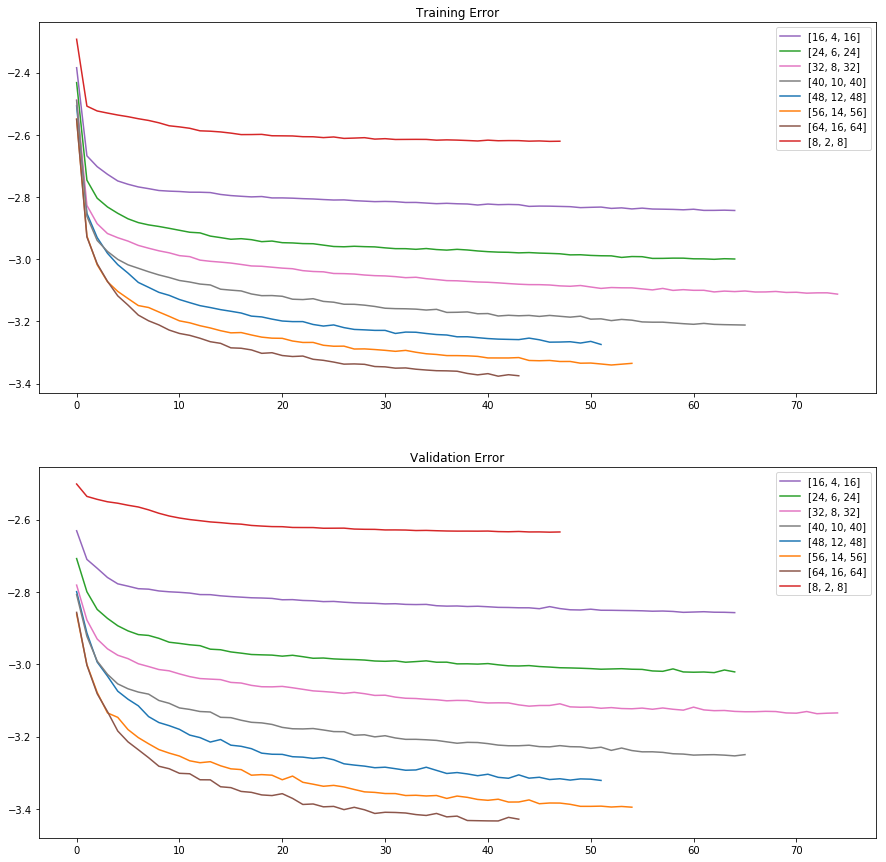

In [6]:
fig=plot_loss_dic(history_dic)